# **Exploratory Data Analysis (EDA)**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:


# ID du Google Sheet
sheet_id = "1a4iZPf93nLejpL7d7LYnF9JliV10etsJS8ia-bw1MXg"

# ID de la feuille (gid)
gid = "356971483"

# URL d'export CSV
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

# Chargement du dataset
df = pd.read_csv(url)

print(" Dataset chargé avec succès !")
print(f"Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print("\nPremières colonnes :")
print(df.columns.tolist())


 Dataset chargé avec succès !
Dimensions : 309 lignes × 201 colonnes

Premières colonnes :
['ID', 'Sexe', 'Age', 'Nationalité', 'Profession (selon catégorie professionnelle)', 'Adresse (Département)', 'Situation Matrimoniale', "Motif(s) d'Admission/Asthénie", "Motif(s) d'Admission/Altération de la fonction rénale", "Motif(s) d'Admission/HTA", "Motif(s) d'Admission/Œdème", "Motif(s) d'Admission/Diabète", "Motif(s) d'Admission/Douleur abdominale", "Autres Motifs d'Admission", 'Personnels Médicaux/HTA', 'Personnels Médicaux/Diabète 1', 'Personnels Médicaux/Diabète 2', 'Personnels Médicaux/IRC', 'Personnels Médicaux/Maladies Cardiovasculaire(Cardiopathie, AVC, preeclampsie)', 'Personnels Médicaux/Ulcère', 'Personnels Médicaux/Pathologies virales (HB, HC, HIV)', 'Autres Antécédents Personnels Médicaux', 'Durée HTA (mois)', 'Durée Diabète 1 (mois)', 'Durée Diabète 2 (mois)', 'Durée IRC (mois)', 'Personnels Chirurgicaux/Appendicectomie', 'Personnels Chirurgicaux/Césarienne', 'Personnels Chiru

=== RÉSUMÉ GÉNÉRAL (INFO) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Columns: 201 entries, ID to Causes Majeure après Diagnostic/Diabète
dtypes: object(201)
memory usage: 485.4+ KB

=== VALEURS MANQUANTES PAR COLONNE ===
                                                   Type de donnée  \
Durée Diabète 1 (mois)                                     object   
Autres détails de l'Enquête Sociale à Préciser             object   
Etat Général (EG)/Autre                                    object   
Autres Antécédents Personnels Familiaux                    object   
Autres Détails de l'Examen Pleuropulmonaire                object   
Pathologies/Artériosclérose                                object   
Autres Pathologies                                         object   
Durée IRC (mois)                                           object   
PB (G/L)                                                   object   
Ret (g/L)                                               

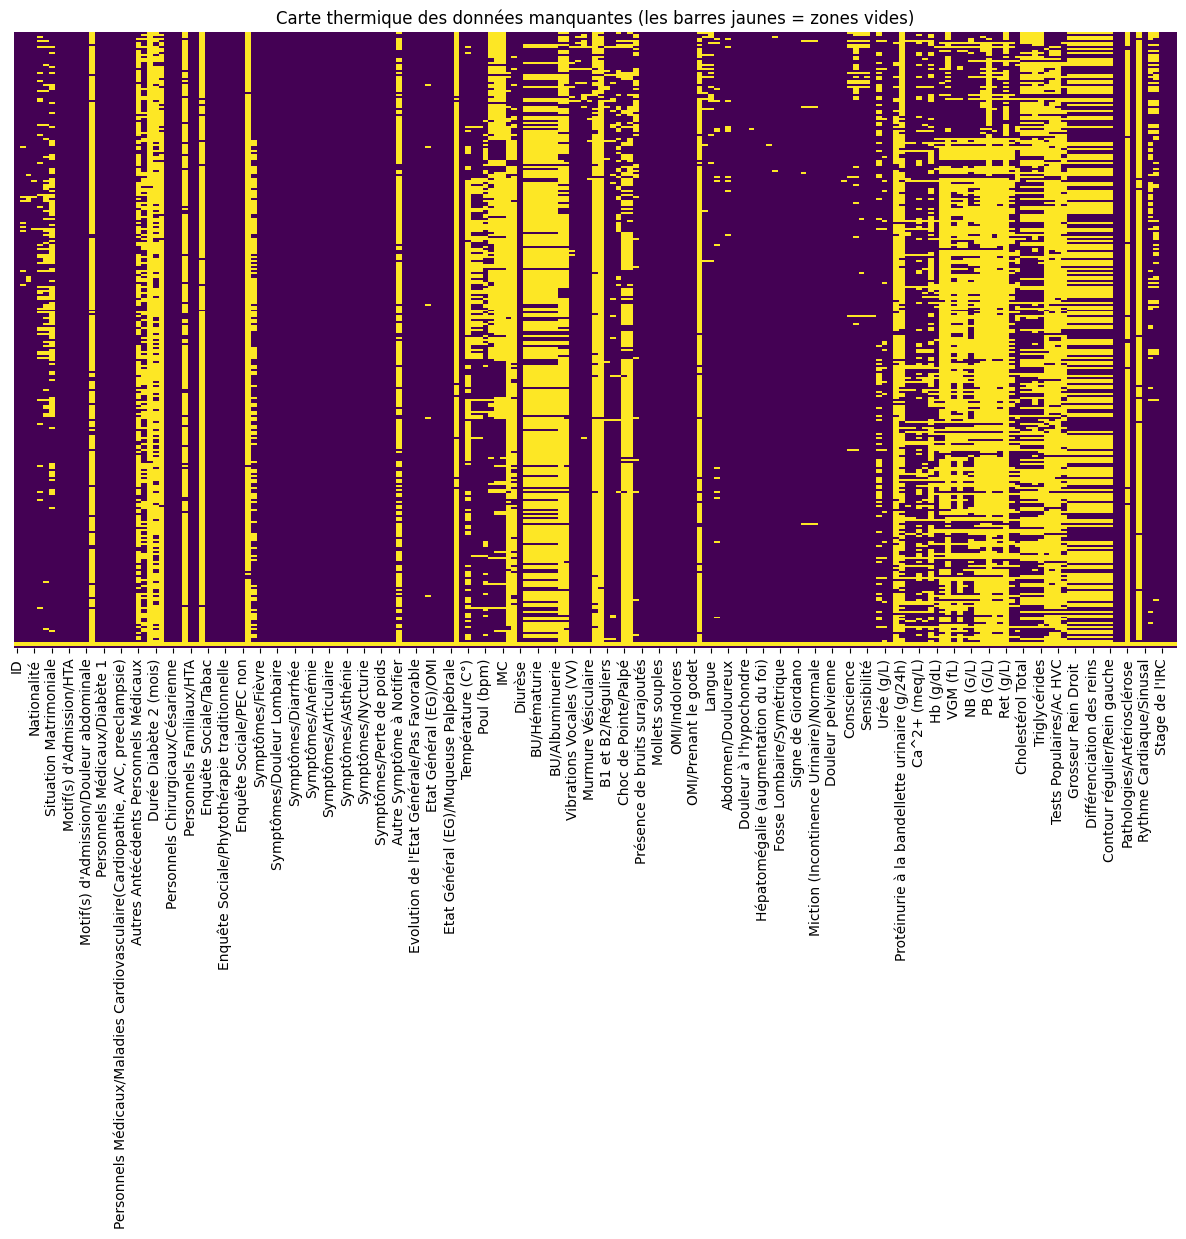

In [6]:
# 1. Résumé compact (Types + non-nuls)
print("=== RÉSUMÉ GÉNÉRAL (INFO) ===")
df.info()

# 2. Analyse détaillée des valeurs manquantes par colonne
print("\n=== VALEURS MANQUANTES PAR COLONNE ===")
missing_data = pd.DataFrame({
    'Type de donnée': df.dtypes,
    'Valeurs Manquantes': df.isnull().sum(),
    'Pourcentage (%)': (df.isnull().sum() / len(df)) * 100
})

# On trie pour voir les colonnes les plus vides en premier
print(missing_data.sort_values(by='Valeurs Manquantes', ascending=False).head(30))

# 3. Visualisation des données manquantes (optionnel)
import seaborn as sns
plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title("Carte thermique des données manquantes (les barres jaunes = zones vides)")
plt.show()


## 1. Problème de Formatage des Données (dtypes)

**Observation :** 100% des colonnes (201 au total) sont détectées comme de type `object` (texte).

**Diagnostic :** Pandas ne reconnaît pas les valeurs numériques. Cela est probablement dû à :
- L'usage de la **virgule comme séparateur décimal** (ex: `12,5`)
- Des **annotations textuelles** dans les cellules biologiques (ex: `3+`, `Négative`)

**Impact :** Aucun calcul statistique (moyenne, corrélation) n'est possible sans une phase de conversion massive.

---

## 2. Analyse de la "Densité" des Données (Heatmap)

**Observation :** La carte thermique montre une dominance du jaune (zones manquantes).

**Diagnostic :** Le dataset est extrêmement "creux". De nombreuses variables cliniques spécialisées ne sont renseignées que pour une minorité de patients.

**Points Forts :** On distingue des colonnes "pleines" (en violet) sur la gauche, correspondant à :
- L'**ID**
- L'**Âge**
- Le **Sexe**
- Certains **antécédents**

---

## 3. Problème de  dimensionnalité

**Observation :** 201 variables pour seulement 309 patients.

**Diagnostic :** Le ratio est trop élevé (presque 1 variable pour 1.5 patient). En l'état, n'importe quel modèle de Machine Learning va **surapprendre** (*overfitting*) sur des bruits statistiques.

#  **Analyse de la variable cible**

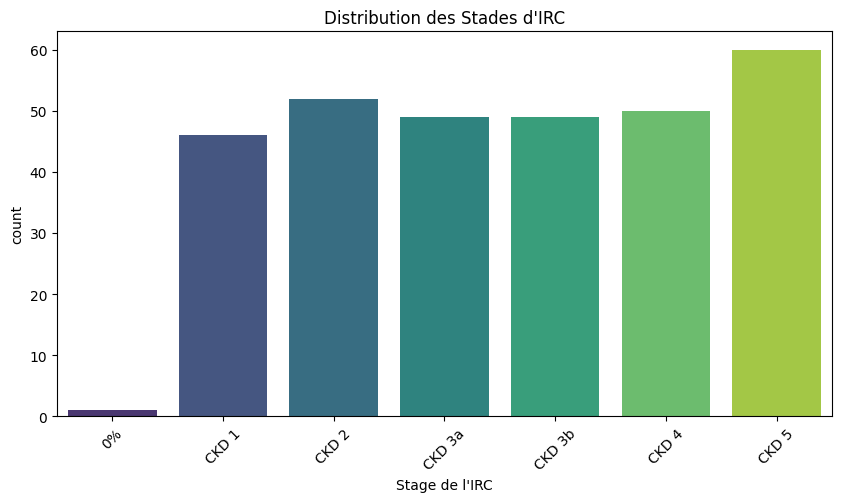

Détails distribution :
Stage de l'IRC
CKD 5     19.543974
CKD 2     16.938111
CKD 4     16.286645
CKD 3a    15.960912
CKD 3b    15.960912
CKD 1     14.983713
0%         0.325733
Name: proportion, dtype: float64


In [5]:
target_col = "Stage de l'IRC"

# Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x=target_col, palette="viridis", order=sorted(df[target_col].dropna().unique()))
plt.title("Distribution des Stades d'IRC")
plt.xticks(rotation=45)
plt.show()

print("Détails distribution :")
print(df[target_col].value_counts(normalize=True) * 100)

**Pour la taille du jeu de données les diffentes proportion de la cible sont plutot equilibrees.Pas de probleme de déséquilibre**

## **Nettoyage des données** 

In [12]:
import re

plus_de_vars = [
    'Age', 'Créatinine (mg/L)', 'Urée (g/L)', 'Hb (g/dL)', 'Poids (Kg)', 'Taille (m)',
    'K^+ (meq/L)', 'Na^+ (meq/L)', 'Ca^2+ (meq/L)', 'Cl^- (meq/L)', 
    'Triglycérides', 'Cholestérol Total',
    'TA (mmHg)/Systole', 'TA (mmHg)/Diastole', 'Température (C°)',
    'Protéinurie à la bandellette urinaire (g/24h)', 'Protéinurie'
]


def robust_numeric_conversion(val):
    if pd.isna(val) or str(val).strip() == "": 
        return np.nan
    
    s = str(val).lower().replace(",", ".").strip()
    

    if any(term in s for term in ["négative", "absent", "trace", "negatif", "negative"]):
        return 0.0
    
  
    plus_match = re.search(r"(\d)\+", s)
    if plus_match:
        val_plus = int(plus_match.group(1))
        # Mapping arbitraire courant en clinique : 1+ -> 0.3, 2+ -> 1, 3+ -> 3
        return 3.0 if val_plus >= 3 else 1.0 if val_plus == 2 else 0.3
    
    # Extraction du premier nombre trouvé (ignore les unités comme "mg/L")
    num_match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    if num_match:
        return float(num_match.group())
    
    return np.nan


for col in plus_de_vars:
    if col in df.columns:
        df[col] = df[col].apply(robust_numeric_conversion)
        print(f" {col} converti. (Valeurs valides: {df[col].notnull().sum()})")

# 1. On filtre la liste pour ne garder que les colonnes qui existent réellement dans le fichier
existing_vars = [col for col in plus_de_vars if col in df.columns]

# 2. Vérification des types sans erreur
print("\nTypes après conversion :")
print(df[existing_vars].dtypes)

# 3. Aperçu
display(df[existing_vars].head())



 Age converti. (Valeurs valides: 300)
 Créatinine (mg/L) converti. (Valeurs valides: 307)
 Urée (g/L) converti. (Valeurs valides: 284)
 Hb (g/dL) converti. (Valeurs valides: 257)
 Poids (Kg) converti. (Valeurs valides: 181)
 Taille (m) converti. (Valeurs valides: 139)
 K^+ (meq/L) converti. (Valeurs valides: 277)
 Na^+ (meq/L) converti. (Valeurs valides: 272)
 Ca^2+ (meq/L) converti. (Valeurs valides: 216)
 Cl^- (meq/L) converti. (Valeurs valides: 258)
 Triglycérides converti. (Valeurs valides: 1)
 Cholestérol Total converti. (Valeurs valides: 1)
 TA (mmHg)/Systole converti. (Valeurs valides: 246)
 TA (mmHg)/Diastole converti. (Valeurs valides: 246)
 Température (C°) converti. (Valeurs valides: 134)
 Protéinurie à la bandellette urinaire (g/24h) converti. (Valeurs valides: 66)
 Protéinurie converti. (Valeurs valides: 62)

Types après conversion :
Age                                              float64
Créatinine (mg/L)                                float64
Urée (g/L)                 

,Age,Créatinine (mg/L),Urée (g/L),Hb (g/dL),Poids (Kg),Taille (m),K^+ (meq/L),Na^+ (meq/L),Ca^2+ (meq/L),Cl^- (meq/L),Triglycérides,Cholestérol Total,TA (mmHg)/Systole,TA (mmHg)/Diastole,Température (C°),Protéinurie à la bandellette urinaire (g/24h),Protéinurie
0,50.0,169.0,1.29,11.4,NaN,NaN,6.4,131.0,82.0,96.0,NaN,NaN,140.0,80.0,37.0,NaN,0.0
1,28.0,17.0,0.66,9.5,NaN,NaN,5.3,134.0,NaN,95.0,NaN,NaN,130.0,80.0,39.0,NaN,3.0
2,69.0,48.0,0.79,9.6,NaN,NaN,3.4,139.0,87.0,100.0,NaN,NaN,93.0,34.0,37.6,NaN,0.0
3,68.0,42.0,1.14,8.2,NaN,NaN,5.7,142.0,88.0,104.0,NaN,NaN,130.0,70.0,37.8,NaN,3.0
4,68.0,500.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.0,111.0,37.0,NaN,3.0


## **Analyse Multivariée**

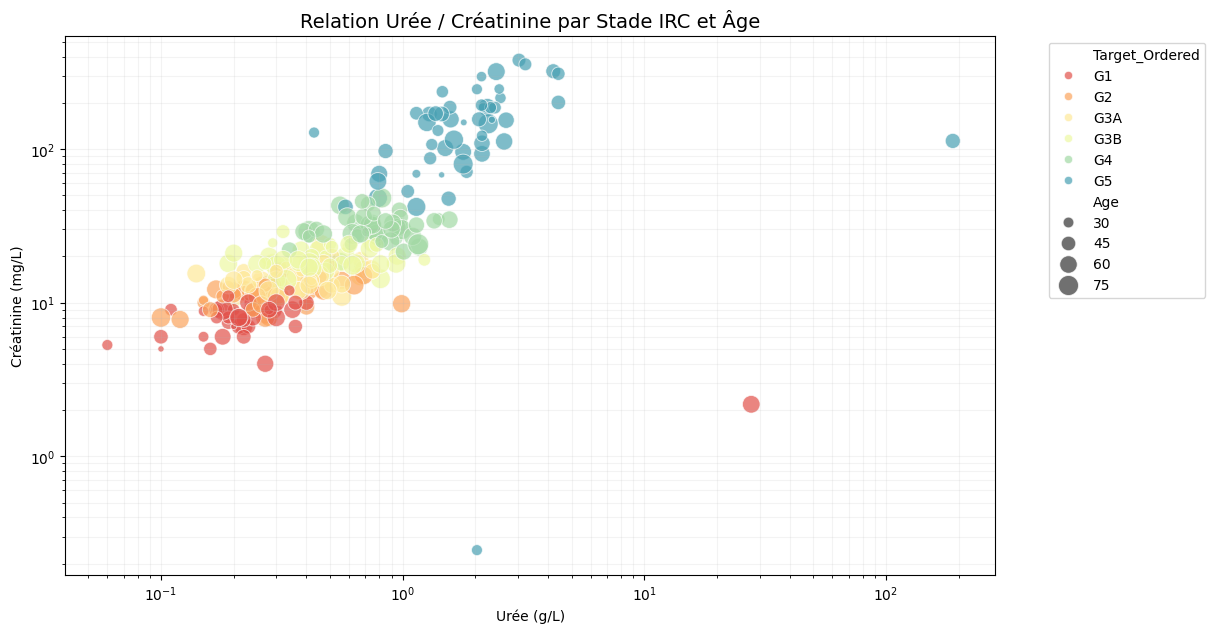

In [15]:
# 1. Définition de l'ordre clinique et nettoyage de la cible
ckd_order = ['G1', 'G2', 'G3A', 'G3B', 'G4', 'G5']
target_col = "Stage de l'IRC"

def map_ckd_stage(val):
    s = str(val).strip().upper()
    if '3A' in s: return 'G3A'
    if '3B' in s: return 'G3B'
    for g in ['1', '2', '4', '5']:
        if g in s: return f'G{g}'
    return "Inconnu"

# Création de la colonne pour le graphique
df['Target_Ordered'] = df[target_col].apply(map_ckd_stage)

# 2. Visualisation des interactions critiques
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df[df['Target_Ordered'] != "Inconnu"], # On filtre les inconnus pour le graphe
    x='Urée (g/L)', 
    y='Créatinine (mg/L)', 
    hue='Target_Ordered', 
    size='Age', 
    sizes=(20, 250),
    hue_order=ckd_order, 
    palette="Spectral", 
    alpha=0.7
)

plt.title("Relation Urée / Créatinine par Stade IRC et Âge", fontsize=14)
plt.xscale('log') 
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Légende à l'extérieur
plt.show()

Ce nuage de points explore la corrélation entre deux marqueurs biologiques clés de la fonction rénale : **l'urée** (g/L) et **la créatinine** (mg/L), croisés avec le stade de l'Insuffisance Rénale Chronique (IRC) et l'âge des patients.

---

## Observations Clés

### 1. Corrélation Positive Forte
- **Relation quasi-linéaire** entre urée et créatinine sur l'échelle logarithmique
- Les deux marqueurs augmentent de concert : quand l'un monte, l'autre suit
- Cohérence clinique : marqueurs de la fonction rénale dégradée

### 2. Gradient des Stades IRC (Couleurs)

| Stade | Couleur | Position sur le graphique | Profil |
|-------|---------|---------------------------|--------|
| **G1** | Rouge | Bas à gauche | Urée < 0.5 g/L, Créatinine ~5-10 mg/L |
| **G2** | Orange | Centre-gauche | Progression modérée |
| **G3A** | Jaune | Centre | Zone de transition |
| **G3B** | Vert clair | Centre-droit | Détérioration notable |
| **G4** | Vert foncé | Droit | Urée ~1-2 g/L, Créatinine ~20-50 mg/L |
| **G5** | Bleu | Haut à droite | Urée > 2 g/L, Créatinine > 100 mg/L |

> **Insight :** Les couleurs forment un **gradient naturel** de bas gauche (sain) vers haut droite (pathologique), validant la classification des stades IRC.

### 3. Impact de l'Âge (Taille des points)

- **Petits points (30 ans)** : Concentrés dans les stades G1-G2
- **Points moyens (45-60 ans)** : Répartis sur G2-G4
- **Gros points (75 ans)** : Présents surtout en G3B-G5

> **Constat :** L'âge est un facteur de risque , les patients âgés occupent majoritairement les stades avancés.

---

## Anomalies et Points d'Intérêt

### Outlier Majeur
- **Point rouge isolé** (G1) à droite du graphique :
  - Urée ~20 g/L (extrêmement élevée)
  - Créatinine ~2 mg/L (anormalement basse pour cette urée)
  - **Hypothèse :** Possible erreur de saisie, patient dialysé, ou condition spécifique (déshydratation sévère)

### Point Bleu Isolé
- **Point G5** en bas à droite :
  - Urée élevée (~2 g/L) mais créatinine très basse (~0.3 mg/L)
  - **À investiguer :** Anomalie biologique ou erreur de mesure

---

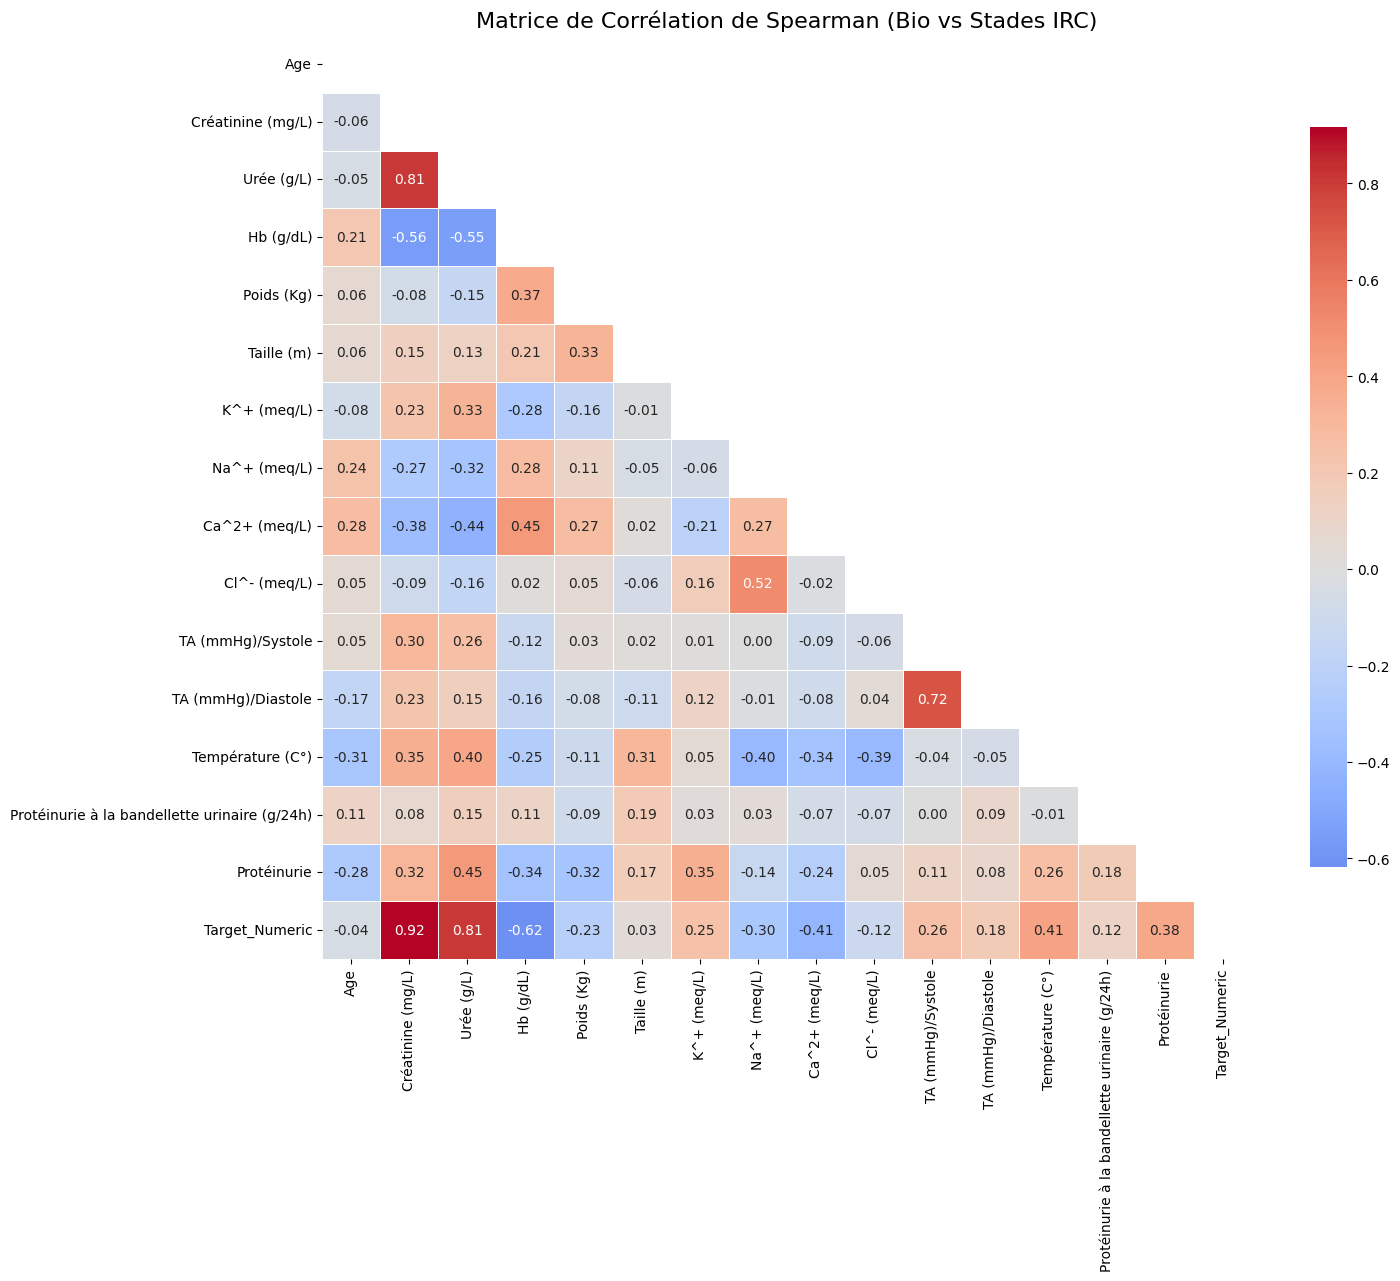


=== Top des variables corrélées au stade de l'IRC (Target) ===
Target_Numeric                                   1.000000
Créatinine (mg/L)                                0.915956
Urée (g/L)                                       0.812518
Température (C°)                                 0.412675
Protéinurie                                      0.383987
TA (mmHg)/Systole                                0.255866
K^+ (meq/L)                                      0.245876
TA (mmHg)/Diastole                               0.182125
Protéinurie à la bandellette urinaire (g/24h)    0.117596
Taille (m)                                       0.032750
Age                                             -0.044003
Cl^- (meq/L)                                    -0.116263
Poids (Kg)                                      -0.227999
Na^+ (meq/L)                                    -0.298749
Ca^2+ (meq/L)                                   -0.413656
Hb (g/dL)                                       -0.617010
Name: Ta

In [16]:
# 1. Encodage numérique de la cible pour la corrélation
stage_map = {'G1': 1, 'G2': 2, 'G3A': 3, 'G3B': 4, 'G4': 5, 'G5': 6}
df['Target_Numeric'] = df['Target_Ordered'].map(stage_map)

# 2. Sélection des colonnes numériques (incluant la cible)
# On ne garde que les colonnes avec au moins 30 valeurs pour éviter les corrélations faussées
cols_for_corr = [col for col in existing_vars if df[col].count() > 30] + ['Target_Numeric']

# 3. Calcul de la corrélation de Spearman (plus robuste pour les stades ordonnés)
corr_matrix = df[cols_for_corr].corr(method='spearman')

# 4. Affichage de la Heatmap
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Masque pour ne voir que la partie inférieure

sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title("Matrice de Corrélation de Spearman (Bio vs Stades IRC)", fontsize=16)
plt.show()

# 5. Focus sur la corrélation avec la cible uniquement
print("\n=== Top des variables corrélées au stade de l'IRC (Target) ===")
print(corr_matrix['Target_Numeric'].sort_values(ascending=False))


## Corrélations Principales et Prédicteurs Clés

La matrice de corrélation de Spearman révèle des relations statistiques robustes entre les biomarqueurs et la sévérité de l'insuffisance rénale chronique. La **créatinine émerge comme le prédicteur dominant** avec un coefficient de corrélation de 0.92 avec le stade IRC cible, ce qui en fait le marqueur biologique le plus fiable pour évaluer la progression de la maladie. Cette corrélation quasi-parfaite s'explique par le mécanisme physiologique direct : la créatinine, produit de dégradation musculaire éliminé exclusivement par les reins, s'accumule de manière prévisible quand la fonction rénale décline. L'**urée suit de près avec un coefficient de 0.81**, confirmant son statut de marqueur complémentaire bien que partiellement redondant avec la créatinine. Ces deux marqueurs présentent d'ailleurs une corrélation de 0.81 entre eux, ce qui pose la question de leur utilisation simultanée dans un modèle prédictif sans traitement préalable pour éviter la multicolinéarité.

## Marqueurs de Complications Systémiques

Au-delà des marqueurs directs de fonction rénale, l'analyse met en lumière des **corrélations négatives significatives révélant les complications systémiques** de l'IRC. L'hémoglobine affiche une corrélation de -0.62 avec le stade IRC et des coefficients de -0.56 et -0.55 respectivement avec la créatinine et l'urée, traduisant l'**anémie de l'insuffisance rénale chronique**. Cette anémie résulte de la diminution de production d'érythropoïétine par les reins lésés, constituant ainsi un marqueur indirect mais puissant de la sévérité rénale. Le calcium sérique présente également des corrélations négatives marquées avec la créatinine (-0.38), l'urée (-0.44) et le stade IRC (-0.41), reflétant les **désordres phosphocalciques** et l'hyperparathyroïdisme secondaire qui accompagnent l'évolution de la maladie. Ces marqueurs, bien que moins directement corrélés au stade IRC que la créatinine, apportent une dimension métabolique essentielle que ce dernier ne capture pas.

## Patterns Électrolytiques et Cardiovasculaires

Les électrolytes révèlent des patterns intéressants qui méritent attention. Le potassium montre une corrélation modérée de 0.33 avec l'urée et 0.25 avec le stade IRC, suggérant un **risque croissant d'hyperkaliémie** dans les formes avancées de la maladie, complication potentiellement fatale nécessitant une surveillance étroite. Le sodium et le calcium présentent des corrélations négatives avec les marqueurs rénaux, cohérentes avec les troubles hydro-électrolytiques de l'IRC. Sur le plan cardiovasculaire, la pression artérielle systolique et diastole affichent une corrélation de 0.72 entre elles, conforme à l'attente physiologique, mais leurs liens avec le stade IRC restent modestes (0.26 et 0.18), indiquant que l'**hypertension artérielle, bien que fréquente chez ces patients, n'est pas un prédicteur linéaire fiable de la sévérité rénale** dans ce dataset.


**Le feature selection effectué est clairement expliqué dans la documentation du travail.**